# DBSCAN

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import colorsys
import time

## Defining the algorithm

### Core idea

DBSCAN clustering has two parameters - $\text{minPts }$and $\varepsilon$. 

A point is said to be a core point if the neighbourhood of radius $\varepsilon$ has atleast $\text{minPts}$ points around it, including itself.

All the points start off as unlabelled. If a point is unlabelled and has a sufficiently dense neighbourhood, then that point is a new cluster. All the points inside the neighbourhood are then put inside a queue. We deque each member and add their neighbourhoods to the queue if the member turns out to be a core point.

If a point is unlabelled and is not a core point then it is labelled as noise. This label may be changed later if it becomes part of some other cluster.

### Algorithm

$$
\begin{array}{ll}
C \gets 0 & \text{/* Cluster counter */} \\
\textbf{for each } P \text{ in } X \textbf{ do } & \\
\quad \quad \textbf{if } label(P) \neq \text{undefined} \textbf{ then continue} & \text{/* Skip if labelled */} \\
\quad\quad N \gets \text{WithinBounds}(X, P, \varepsilon) & \text{/* Find neighbors */} \\
\quad\quad \textbf{if } |N| < \text{minPts} \textbf{ then } & \\
\quad \quad\quad\quad label(P) \gets \text{Noise} & \text{/* Mark as noise */} \\
\quad \quad\quad\quad \textbf{continue} & \\
\quad\quad C \gets C + 1 & \text{/* Increment cluster label */} \\
\quad\quad label(P) \gets C & \\
\quad\quad Q \gets \text{Queue}(N \setminus \{P\}) & \text{/* Initialize queue */} \\
\quad\quad \textbf{while } Q \text{ is not empty} \textbf{ do } & \\
\quad\quad\quad \quad S \gets \text{dequeue}(Q) & \\
\quad\quad\quad \quad \textbf{if } label(S) = \text{Noise} \textbf{ then } label(S) \gets C & \text{/* Convert noise to border point */} \\
\quad\quad\quad \quad \textbf{if } label(S) \neq \text{undefined} \textbf{ then continue} & \text{/* Skip if labelled */} \\
\quad\quad\quad \quad label(S) \gets C & \text{/* Assign cluster */} \\
\quad\quad\quad \quad N' \gets \text{WithinBounds}(X,  S, \varepsilon) & \\
\quad\quad\quad \quad \textbf{if } |N'| \geq \text{minPts} \textbf{ then } Q \gets Q \cup N' & \text{/* Expand cluster */} \\
\textbf{end for} &
\end{array}
$$


In [2]:
class DBSCAN:
    def __init__(self, X, minPts, epsilon):
        self.X = X  # X is the dataset
        self.epsilon = epsilon  # epsilon is the distance within which the number of points must be considered
        self.minPts = minPts  # minPts is the minimum number of points required to consider a point a core point
        self.y_pred = np.full(X.shape[0], np.nan)  # Labels each point, default is np.nan since -1 is used for noise

    # Returns all the points that is within epsilon distance from a point
    def within_bounds(self, core):
        # Calculate the Euclidean distances from the core point to all other points
        distances = np.linalg.norm(self.X - core, axis=1)

        # Get the points within the epsilon distance
        neighbours = self.X[distances <= self.epsilon]

        return neighbours

    # Runs the DBSCAN algorithm
    def run(self):
        start = time.time_ns()
        # Starts the cluster index at -1. It gets incremented to zero before the first cluster assignment. Lowest cluster number is 0
        cluster = -1
        # Loops through all the points in the dataset
        for i, point in enumerate(self.X):
            # If the point P has not been labelled in an earlier loop, continue
            if np.isnan(self.y_pred[i]):
                neighbours = np.copy(
                    self.within_bounds(point))  # Get all the points within a distance epsilon from point P
                if neighbours.shape[0] < self.minPts:  # If the number of points is less than minPts, assign it as noise
                    self.y_pred[i] = -1  # Setting to noise label

                # If the number of neighbouring points is >= minPts, the point P is a core point and is a new cluster
                else:
                    cluster += 1  # Increment cluster index before assigning
                    self.y_pred[i] = cluster
                    seeds = np.array(list(set(map(tuple, neighbours)) - {tuple(
                        point)}))  # Potential core points that surround point P that belong to the same cluster excluding P itself
                    # Loops through all the potential seed in seeds
                    for seed in seeds:
                        index = np.where(self.X == seed)[0][0]  # Gets the index of each seed point S
                        if self.y_pred[
                            index] == -1:  # If label of S is noise, set it to be the current cluster (It cant be a core point because it was previously labelled as noise)
                            self.y_pred[index] = cluster
                        if np.isnan(self.y_pred[
                                        index]):  # If the label is not defined, set it as the current cluster and check if S is a core point
                            self.y_pred[index] = cluster
                            seed_neighbours = np.copy(self.within_bounds(seed))  # Get all the neighbour of seed S
                            mask = np.array([not np.all(neighbour == seed) for neighbour in
                                             seed_neighbours])  # Get all the neighbours of S except S itself
                            seed_neighbours = seed_neighbours[mask]
                            if seed_neighbours.shape[0] >= self.minPts:
                                seeds = np.vstack(
                                    (seeds, seed_neighbours))  # Append all the new seed_neighbours to seeds list
        end = time.time_ns()
        print((1e-6 * (end - start)) // 1, 'milliseconds taken')
        return self.y_pred


## Visualising the clusters

Do you want default params? Y/N :  y


Seed : 808
190.0 milliseconds taken
1 iterations to converge.
3 clusters


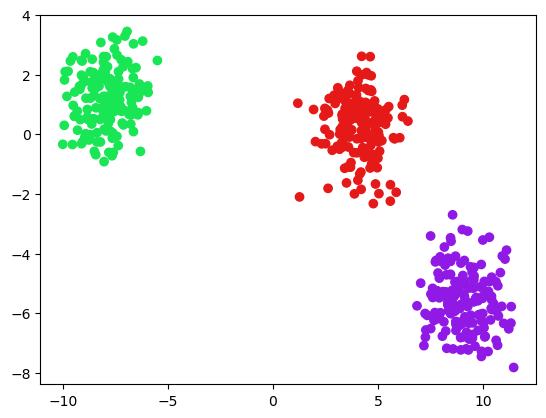

In [10]:
WHITE = (255, 255, 255)
GREY = (195, 195, 195)
BLACK = (0, 0, 0)


# Color function to generate distinct colors based on a seed/number
# I stole this code. Don't know why or how it works. Just needed random colors
def colors(num):
    if num == -1:
        return np.array(GREY)/255
    hue = (num * 137.508) % 360  # Use golden angle approximation and keep the hue within [0, 360)
    saturation = 0.8
    lightness = 0.5

    r, g, b = colorsys.hls_to_rgb(hue / 360, lightness, saturation)

    return np.array([r,g,b])

# Returns a gaussian mixture with desired number of clusters
def get_random_data(num_points, centers, seed=None):
    if seed is None:
        seed = np.random.randint(1, 1000)
    print(f"Seed : {seed}")
    X, Y = make_blobs(n_samples=num_points, n_features=2, centers=centers, cluster_std=1.0, random_state=seed)
    # Returns both the datapoints and the actual cluster numbers, although it is not used
    return X, Y, seed


# Displays the datapoints as well as the centroids (if any)
def show_data(X, Y_pred):
    plt.scatter(X[:,0],X[:,1],color = [colors(label) for label in Y_pred])
    plt.show()


def setup_dbscan(X, minPts, epsilon):
    cluster = DBSCAN(X, minPts, epsilon)
    y_pred_hist = np.asarray([cluster.run()], dtype='int32')
    return y_pred_hist
    

def distortion(X, y_pred, centroid):
    centroid = np.asarray(centroid)
    distortion = 0
    for i in range(X.shape[0]):
        # print(i, X[i], y_pred[i], centroid[y_pred[i]], np.linalg.norm(X[i] - centroid[y_pred[i]]))
        distortion += np.linalg.norm(X[i] - centroid[y_pred[i]])
    return distortion / X.shape[0]

def menu_driven(default_params = None):
    if default_params is None:
        centers = int(input("Enter number of centers for the random data : "))
        
        minPts = int(input("Enter minPts : "))
        
        eps = float(input("Enter epsilon : "))
    
        seed = input("Enter the seed if any. Type None for random seed : ")
        if seed.lower() == "none":
            seed = None
        else:
            seed = int(seed)
    
        num_points = int(input("Enter the number of points : "))
    else:
        centers, minPts, eps, seed, num_points = default_params

    X, _, seed = get_random_data(num_points, centers, seed)
    
    y_pred_hist = setup_dbscan(X, minPts, eps)

    print(f"{len(y_pred_hist)} iterations to converge.")
    print(np.max(y_pred_hist) + 1, "clusters")

    return X, y_pred_hist

op = input("Do you want default params? Y/N : ")
if op.lower() == 'y':
    def_params = [3, 20, 4, None, 500]
else:
    def_params = None

X, y_pred_hist = menu_driven(def_params)
show_data(X,np.asarray(y_pred_hist[-1]))